# Лабораторная работа: Обучение модели линейной регрессии на датасете Video Game Sales

## Цель работы
Провести обучение модели линейной регрессии на датасете, выполнив следующие этапы:
- Подготовка данных и первичный анализ
- Визуализация распределения признаков и целевой переменной
- Предобработка данных
- Построение матрицы корреляций
- Анализ мультиколлинеарности (расчет VIF-коэффициента)
- Построение регрессионных моделей (линейная и гребневая)
- Разделение на тренировочную и тестовую выборки (80/20)
- Использование кросс-валидации
- Оценка качества с помощью метрик RMSE, R² и MAPE
- Устранение мультиколлинеарности и снижение размерности с помощью PCA после стандартизации
- Построение моделей на главных компонентах и сравнение метрик

## Датасет
Video Game Sales

## Описание переменных

| Переменная | Описание | Статус |
|------------|-----------|---------|
| Rank | Ранг по глобальным продажам | **ИСКЛЮЧАЕМ** (зависит от целевой) |
| Name | Название игры | **ИСКЛЮЧАЕМ** (почти уникальное) |
| Platform | Платформа | Категориальный признак |
| Year | Год выпуска | Числовой признак |
| Genre | Жанр | Категориальный признак |
| Publisher | Издатель | Категориальный признак |
| NA_Sales | Продажи в Северной Америке | **ИСКЛЮЧАЕМ** (data leakage) |
| EU_Sales | Продажи в Европе | **ИСКЛЮЧАЕМ** (data leakage) |
| JP_Sales | Продажи в Японии | **ИСКЛЮЧАЕМ** (data leakage) |
| Other_Sales | Продажи в других регионах | **ИСКЛЮЧАЕМ** (data leakage) |
| Global_Sales | Общие мировые продажи | **ЗАВИСИМАЯ ПЕРЕМЕННАЯ** |

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
dataset = pd.read_csv('vgsales.csv')
dataset = dataset.drop(columns=['Rank', 'Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'])
print(dataset)

      Platform    Year         Genre   Publisher  Global_Sales
0          Wii  2006.0        Sports    Nintendo         82.74
1          NES  1985.0      Platform    Nintendo         40.24
2          Wii  2008.0        Racing    Nintendo         35.82
3          Wii  2009.0        Sports    Nintendo         33.00
4           GB  1996.0  Role-Playing    Nintendo         31.37
...        ...     ...           ...         ...           ...
16593      GBA  2002.0      Platform       Kemco          0.01
16594       GC  2003.0       Shooter  Infogrames          0.01
16595      PS2  2008.0        Racing  Activision          0.01
16596       DS  2010.0        Puzzle    7G//AMES          0.01
16597      GBA  2003.0      Platform     Wanadoo          0.01

[16598 rows x 5 columns]


## Подготовка данных: первичный анализ, визуализация распределения признаков и целевой переменной

Global_Sales имеет сильную асимметрию (long-tail), поэтому добавляем лог-трансформацию для лучшей визуализации.

In [5]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Platform      16598 non-null  object 
 1   Year          16327 non-null  float64
 2   Genre         16598 non-null  object 
 3   Publisher     16540 non-null  object 
 4   Global_Sales  16598 non-null  float64
dtypes: float64(2), object(3)
memory usage: 648.5+ KB
None


вывели данные, можно увидеть типы данных переменных и отсутвие нулевых(NaN) значений

In [6]:
print(dataset.describe())

               Year  Global_Sales
count  16327.000000  16598.000000
mean    2006.406443      0.537441
std        5.828981      1.555028
min     1980.000000      0.010000
25%     2003.000000      0.060000
50%     2007.000000      0.170000
75%     2010.000000      0.470000
max     2020.000000     82.740000


Year
-----------------------
Эксцесс: 1.847
Асимметрия: -1.002
Колмогорова-Смирнова p-value: 2.038020559364404e-155
Колмогорова-Смирнова статистика: 0.104
Колмогорова-Смирнова нормальность: False
p_value: 0.05
-----------------------


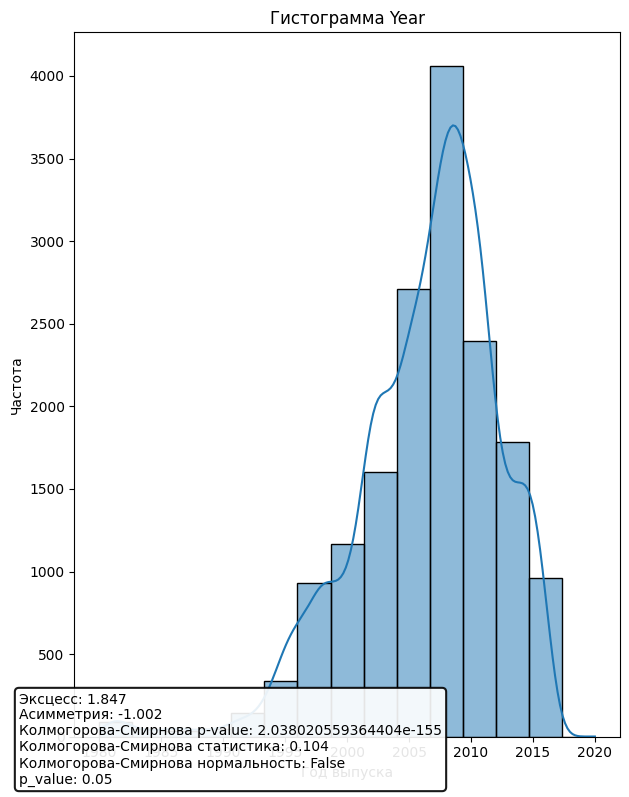

Global_Sales
-----------------------
Эксцесс: 603.750
Асимметрия: 17.399
Колмогорова-Смирнова p-value: 0.0
Колмогорова-Смирнова статистика: 0.367
Колмогорова-Смирнова нормальность: False
p_value: 0.05
-----------------------


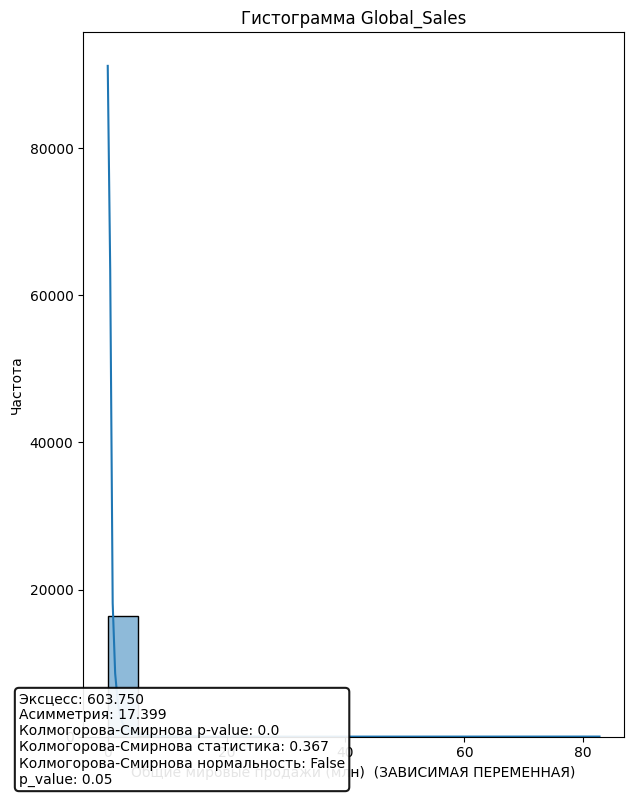

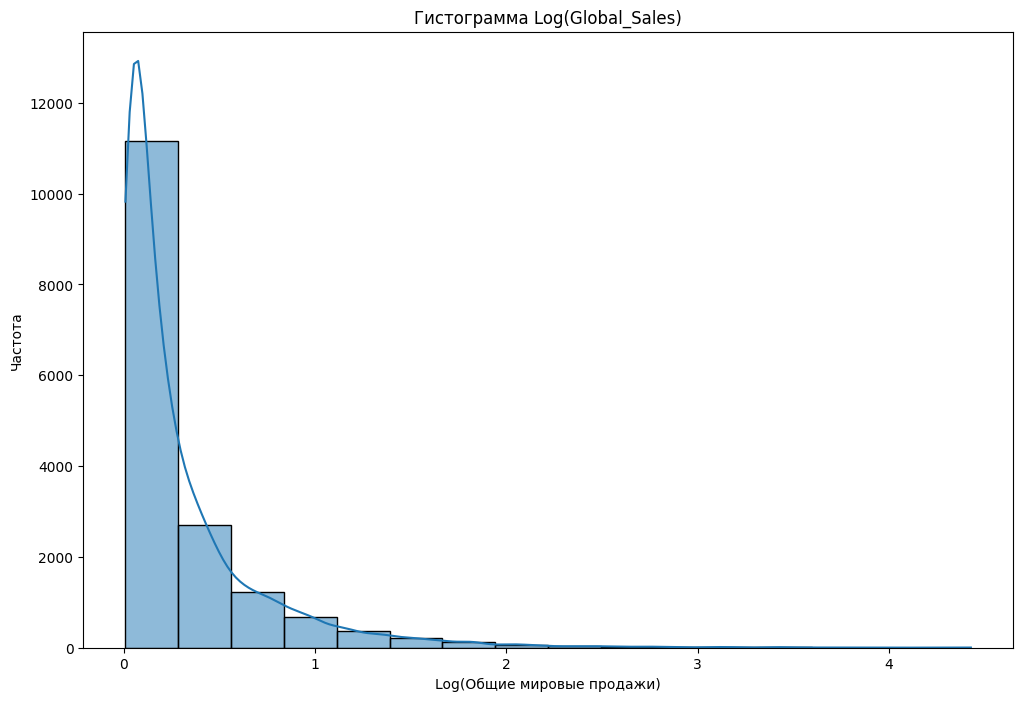

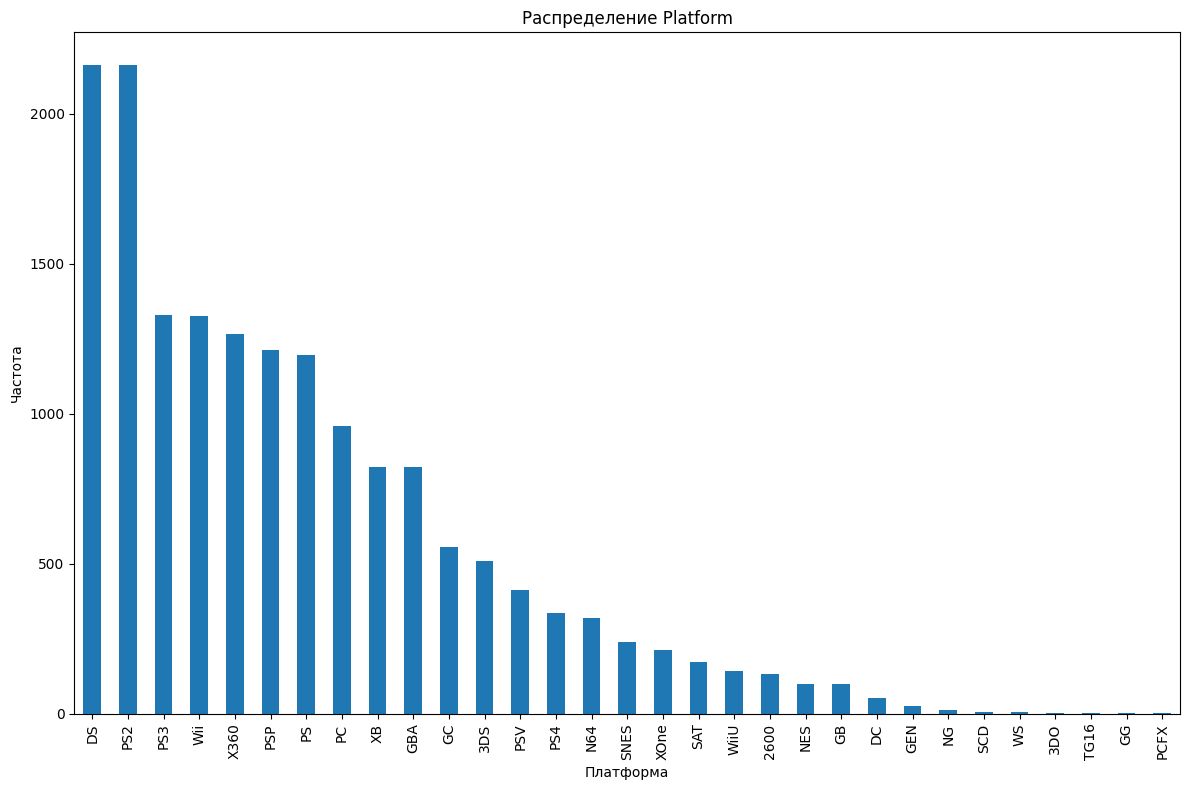

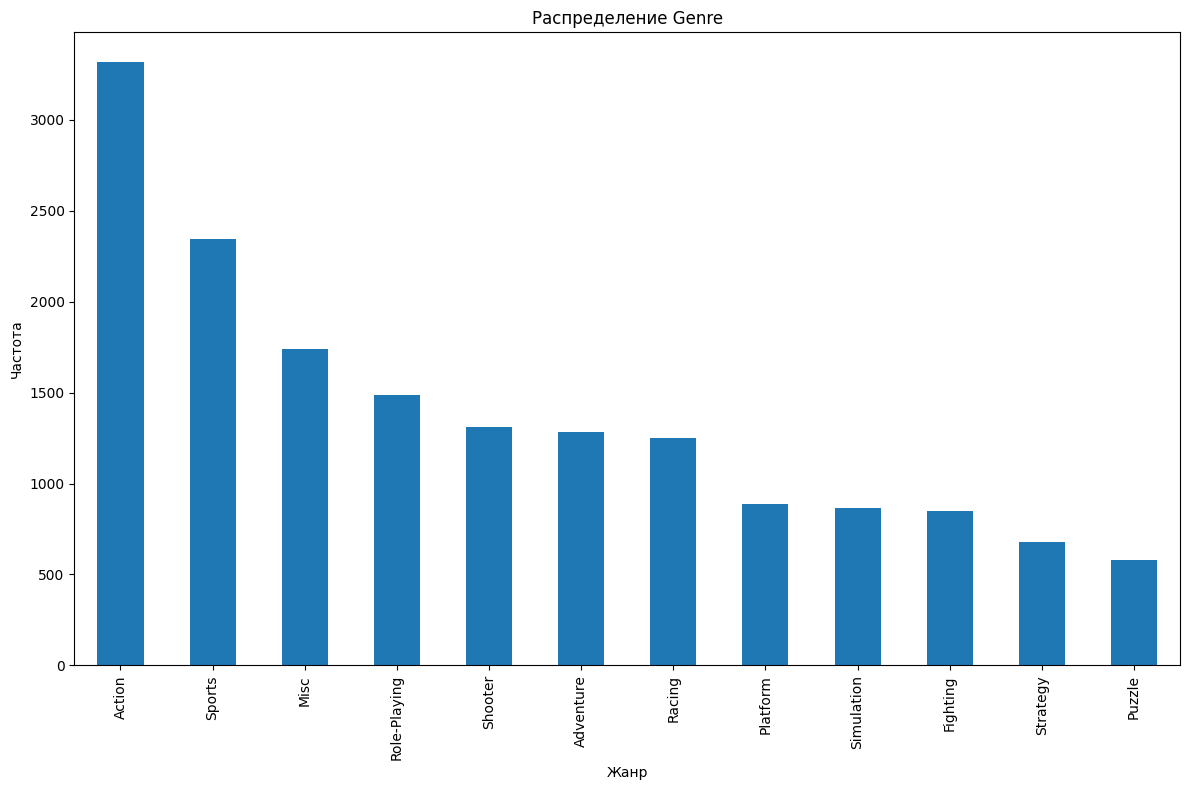

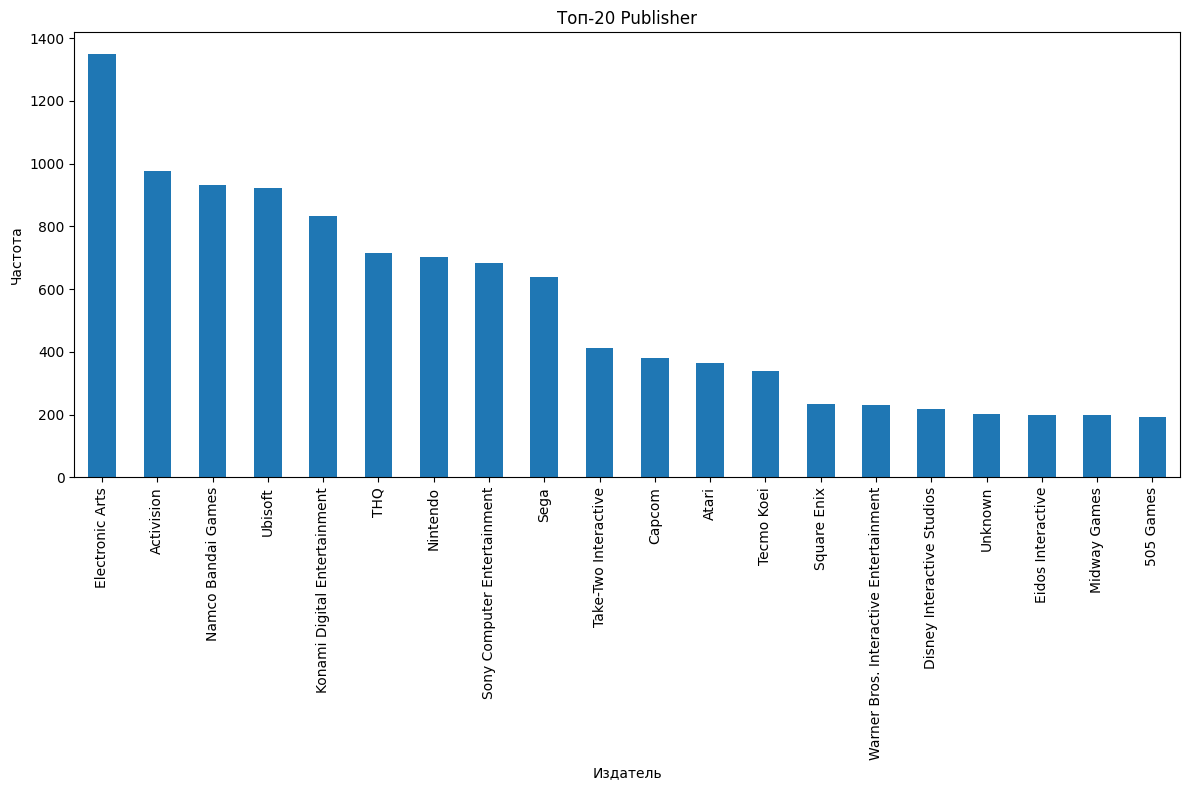

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, kstest
import numpy as np

ALPHA = 0.05

descriptions = {
    'Year': 'Год выпуска',
    'Global_Sales': 'Общие мировые продажи (млн)  (ЗАВИСИМАЯ ПЕРЕМЕННАЯ)',
}

numerical_cols = ['Year', 'Global_Sales']

for col in numerical_cols:
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    sns.histplot(dataset[col].dropna(), kde=True, bins='sturges')
    
    kstestObject = kstest(dataset[col].dropna(), 'norm', 
                         args=(np.mean(dataset[col].dropna()), 
                               np.std(dataset[col].dropna())))
    
    legendText = (f'Эксцесс: {kurtosis(dataset[col].dropna()):.3f}\n'
                  f'Асимметрия: {skew(dataset[col].dropna()):.3f}\n'
                  f'Колмогорова-Смирнова p-value: {kstestObject.pvalue}\n'
                  f'Колмогорова-Смирнова статистика: {kstestObject.statistic:.3f}\n'
                  f'Колмогорова-Смирнова нормальность: {kstestObject.pvalue >= ALPHA}\n'
                  f'p_value: {ALPHA}')
    
    plt.figtext(0.02, 0.01, legendText,
                ha='left',
                va='bottom',
                fontsize=10,
                bbox=dict(boxstyle='round',
                         facecolor='white',
                         edgecolor='black',
                         linewidth=1.5,
                         alpha=0.9))
    
    plt.subplots_adjust(bottom=0.5)
    print(col)
    print('-----------------------')
    print(legendText)
    print('-----------------------')
    
    plt.title(f'Гистограмма {col}')
    plt.xlabel(descriptions[col])
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

# Лог-трансформация для Global_Sales
dataset['Global_Sales_log'] = np.log1p(dataset['Global_Sales'])

plt.figure(figsize=(12, 8))
sns.histplot(dataset['Global_Sales_log'].dropna(), kde=True, bins='sturges')
plt.title('Гистограмма Log(Global_Sales)')
plt.xlabel('Log(Общие мировые продажи)')
plt.ylabel('Частота')
plt.show()

# Визуализация категориальных переменных
plt.figure(figsize=(12, 8))
dataset['Platform'].value_counts().plot(kind='bar')
plt.title('Распределение Platform')
plt.xlabel('Платформа')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
dataset['Genre'].value_counts().plot(kind='bar')
plt.title('Распределение Genre')
plt.xlabel('Жанр')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
dataset['Publisher'].value_counts().head(20).plot(kind='bar')
plt.title('Топ-20 Publisher')
plt.xlabel('Издатель')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

# Анализ распределения числовых переменных

На основе рассчитанных статистик (эксцесс, асимметрия, тест Колмогорова-Смирнова) проведём анализ распределений для переменных Year и Global_Sales. Анализ показывает, что ни одно из распределений не является нормальным, что ожидаемо для данных о видеоиграх: год выпуска ограничен историческим периодом, а продажи имеют "long-tail" характер (много игр с низкими продажами, мало хитов).

## Year (Год выпуска)

- **Эксцесс (Kurtosis = 1.847)**: Положительный эксцесс указывает на лептокуртическое распределение — более "пиковое" и с более тяжёлыми хвостами, чем нормальное. Это означает, что данные сосредоточены вокруг моды (пика), но есть outliers в хвостах (например, старые игры 1980-х или новые после 2010-х).

- **Асимметрия (Skew = -1.002)**: Отрицательная асимметрия — распределение скошено влево. Хвост тянется в сторону меньших значений (больше игр выпущено в последние годы, меньше в ранние).

- **Тест Колмогорова-Смирнова**: Статистика = 0.104, p-value ≈ 2.04e-155 (крайне малое, << 0.05). Распределение значительно отличается от нормального. Нормальность: False.

**Выводы**: Распределение не нормально, с пиком в 2000-х годах (эпоха расцвета игровой индустрии). Для моделирования может потребоваться обработка пропусков (271 NaN) и возможно биннинг или использование как категориальной переменной. Асимметрия предполагает, что недавние игры могут влиять на продажи иначе, чем старые.

## Global_Sales (Общие мировые продажи)

- **Эксцесс (Kurtosis = 603.750)**: Очень высокий положительный эксцесс — экстремально лептокуртическое распределение. Это указывает на наличие огромного количества outliers (хитовые игры с продажами >10 млн), а основная масса данных сосредоточена около нуля (многие игры продаются слабо).

- **Асимметрия (Skew = 17.399)**: Сильно положительная асимметрия — распределение скошено вправо с длинным хвостом (long-tail). Большинство игр имеют низкие продажи (<1 млн), но есть редкие суперхиты (например, Wii Sports ~82 млн).

- **Тест Колмогорова-Смирнова**: Статистика = 0.367, p-value = 0.0 (<< 0.05). Распределение значительно отличается от нормального. Нормальность: False.

In [10]:
dataset_new = dataset.replace('?', pd.NA).dropna()

print(f"Исходный размер: {dataset.shape}")
print(f"Размер после удаления пропущенных значений: {dataset_new.shape}")

Исходный размер: (16598, 6)
Размер после удаления пропущенных значений: (16291, 6)


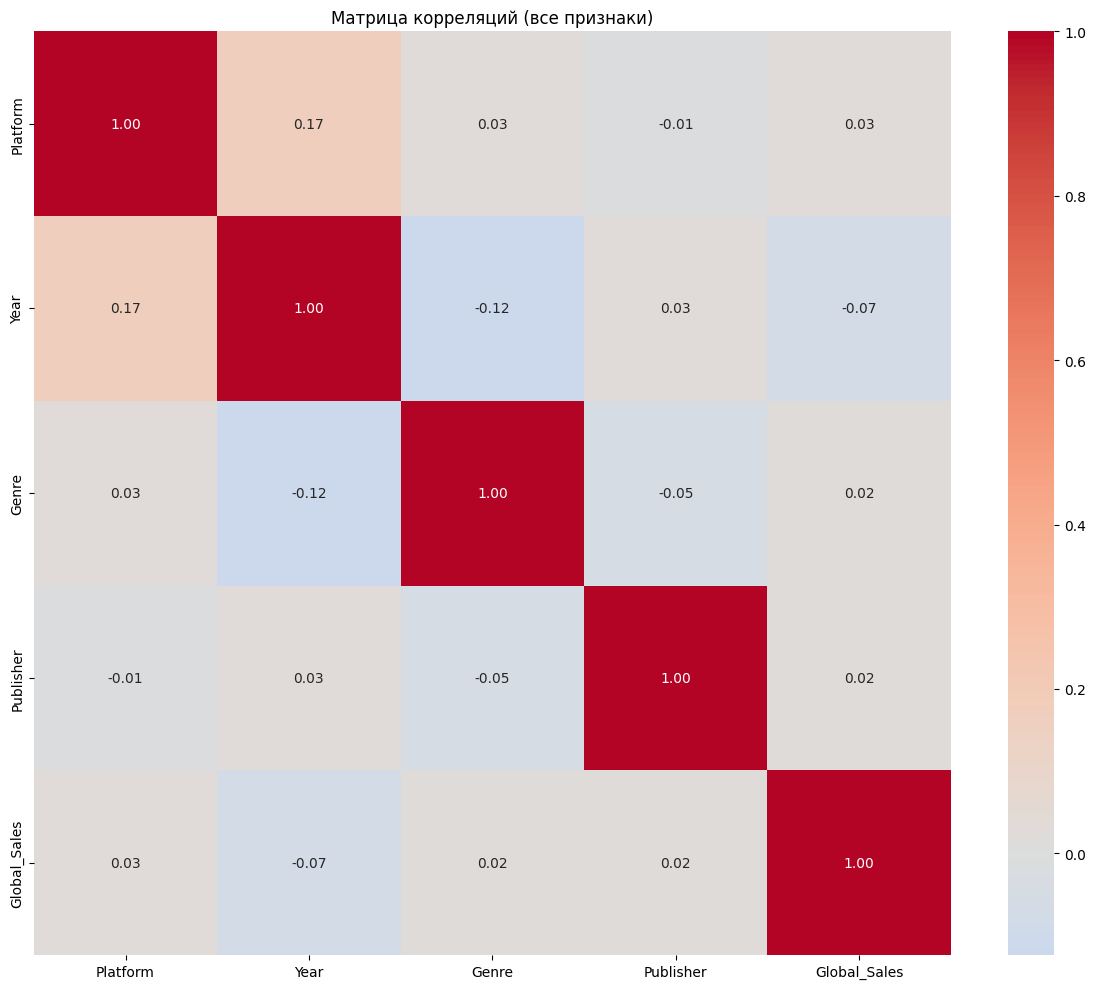

In [25]:
dataset = dataset.copy() 
dataset['Year'] = dataset['Year'].fillna(dataset['Year'].median())
dataset['Publisher'] = dataset['Publisher'].fillna(dataset['Publisher'].mode()[0])

from sklearn.preprocessing import LabelEncoder

dataset_encoded = dataset.copy()

label_encoders = {}
categorical_columns = ['Platform', 'Genre', 'Publisher']

for col in categorical_columns:
    le = LabelEncoder()
    dataset_encoded[col] = le.fit_transform(dataset_encoded[col].astype(str))
    label_encoders[col] = le

plt.figure(figsize=(12, 10))
correlation_matrix = dataset_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Матрица корреляций (все признаки)')
plt.tight_layout()
plt.show()


## Сделать выводы о наличии мультиколлинеарности (расчет VIF-коэффициента)
### Нормализация Данных MinMax методом и расчет VIF-коэффициентов:

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(data):
    """Рассчитать VIF для всех признаков"""
    X = add_constant(data)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data = vif_data.sort_values('VIF', ascending=False)
    return vif_data

print("VIF анализ для закодированных признаков:")
vif_results = calculate_vif(dataset_encoded.drop('Global_Sales', axis=1))
print(vif_results)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = dataset_encoded.drop('Global_Sales', axis=1)
y = dataset_encoded['Global_Sales']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nРазмеры выборок:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("\nПервые 5 строк масштабированных тренировочных данных:")
print(X_train_scaled.head())

VIF анализ для закодированных признаков:
     Feature            VIF
0      const  125953.261205
2       Year       1.046907
1   Platform       1.031254
3      Genre       1.020374
4  Publisher       1.003351

Размеры выборок:
X_train: (13278, 4), X_test: (3320, 4)
y_train: (13278,), y_test: (3320,)

Первые 5 строк масштабированных тренировочных данных:
       Platform      Year     Genre  Publisher
14303  0.384806 -0.072318 -0.511150   0.268874
13455 -1.406855  0.272966  1.086429   1.312356
6724   0.145918  1.481460 -1.309939   0.866761
898   -0.331858 -0.590244  1.086429  -0.870496
8484  -1.406855  0.618250  0.553903   0.973929


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    results = {
        'Model': model_name,
        'RMSE_train': rmse_train,
        'RMSE_test': rmse_test,
        'R2_train': r2_train,
        'R2_test': r2_test,
        'MAPE_train': mape_train,
        'MAPE_test': mape_test,
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std()
    }
    
    return results, y_pred_test

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0)
}

results_before_pca = []
predictions = {}

print("МЕТРИКИ ДО ПРИМЕНЕНИЯ PCA:")
print("=" * 80)

for name, model in models.items():
    results, y_pred = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    results_before_pca.append(results)
    predictions[name] = y_pred
    
    print(f"\n{name}:")
    print(f"  RMSE (train/test): {results['RMSE_train']:.4f} / {results['RMSE_test']:.4f}")
    print(f"  R² (train/test): {results['R2_train']:.4f} / {results['R2_test']:.4f}")
    print(f"  MAPE (train/test): {results['MAPE_train']:.2f}% / {results['MAPE_test']:.2f}%")
    print(f"  Cross-val R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")

results_df_before = pd.DataFrame(results_before_pca)
print("\nСводная таблица метрик до PCA:")
print(results_df_before.round(4))

МЕТРИКИ ДО ПРИМЕНЕНИЯ PCA:

Linear Regression:
  RMSE (train/test): 1.3973 / 2.0464
  R² (train/test): 0.0097 / 0.0033
  MAPE (train/test): 632.36% / 607.80%
  Cross-val R²: 0.0061 (±0.0057)

Ridge Regression:
  RMSE (train/test): 1.3973 / 2.0464
  R² (train/test): 0.0097 / 0.0033
  MAPE (train/test): 632.37% / 607.81%
  Cross-val R²: 0.0061 (±0.0057)

Сводная таблица метрик до PCA:
               Model  RMSE_train  RMSE_test  R2_train  R2_test  MAPE_train  \
0  Linear Regression      1.3973     2.0464    0.0097   0.0033    632.3627   
1   Ridge Regression      1.3973     2.0464    0.0097   0.0033    632.3672   

   MAPE_test  CV_R2_mean  CV_R2_std  
0   607.8021      0.0061     0.0057  
1   607.8065      0.0061     0.0057  


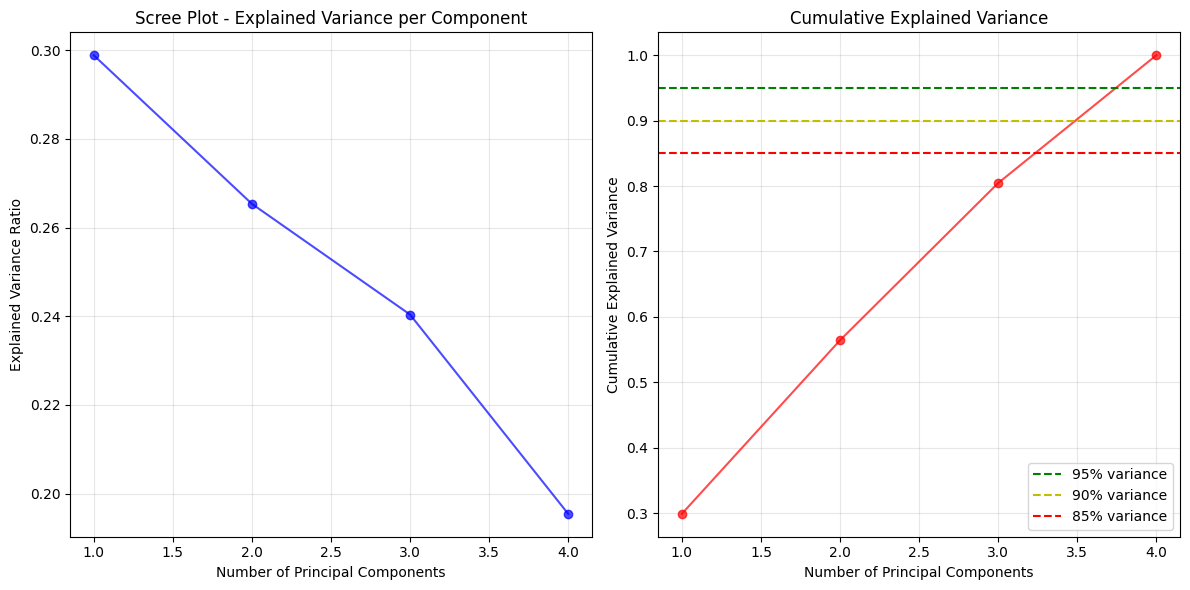

Объясненная дисперсия по компонентам:
Компонента 1: 0.2988 (0.2988 кумулятивно)
Компонента 2: 0.2653 (0.5642 кумулятивно)
Компонента 3: 0.2404 (0.8045 кумулятивно)
Компонента 4: 0.1955 (1.0000 кумулятивно)

Оптимальное число компонент:
Для 95% дисперсии: 4
Для 90% дисперсии: 4
Для 85% дисперсии: 4

Выбрано 4 компонент(ы) для дальнейшего анализа


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA()
X_pca_full = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(12, 6))

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-', alpha=0.7)
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - Explained Variance per Component')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', alpha=0.7)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance')
plt.axhline(y=0.90, color='y', linestyle='--', label='90% variance')
plt.axhline(y=0.85, color='r', linestyle='--', label='85% variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Объясненная дисперсия по компонентам:")
for i, (variance, cum_var) in enumerate(zip(explained_variance, cumulative_variance), 1):
    print(f"Компонента {i}: {variance:.4f} ({cum_var:.4f} кумулятивно)")

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1

print(f"\nОптимальное число компонент:")
print(f"Для 95% дисперсии: {n_components_95}")
print(f"Для 90% дисперсии: {n_components_90}") 
print(f"Для 85% дисперсии: {n_components_85}")

selected_components = n_components_90 
print(f"\nВыбрано {selected_components} компонент(ы) для дальнейшего анализа")

# Вывод по анализу моделей до PCA

## Анализ мультиколлинеарности (VIF)

**Результаты VIF:**
- Константа: 125,953.26 (ожидаемо высокое)
- Year: 1.05
- Platform: 1.03  
- Genre: 1.02
- Publisher: 1.00

**Вывод**: Мультиколлинеарность отсутствует (все VIF < 5)

## Результаты моделей регрессии

**Метрики качества (тестовая выборка):**
- RMSE: 2.0464
- R²: 0.0033 (0.33%)
- MAPE: 607.80%
- Cross-val R²: 0.0061 ± 0.0057

## Ключевые проблемы

1. **Низкая предсказательная способность**
   - R² = 0.33% означает объяснение менее 1% дисперсии
   - Модели не лучше предсказания средним значением

2. **Высокая ошибка прогноза**
   - MAPE > 600% указывает на катастрофическую точность
   - Связано с сильной асимметрией распределения Global_Sales

3. **Неинформативность признаков**
   - Текущие признаки слабо связаны с продажами
   - Отсутствие переобучения подтверждает недостаток предсказательной силы

ПРИМЕНЕНИЕ PCA И ПОСТРОЕНИЕ МОДЕЛЕЙ НА ГЛАВНЫХ КОМПОНЕНТАХ
Применен PCA с 4 компонентами
Объясненная дисперсия: 1.0000

Linear Regression (PCA):
  RMSE (train/test): 1.3973 / 2.0464
  R² (train/test): 0.0097 / 0.0033
  MAPE (train/test): 632.36% / 607.80%
  Cross-val R²: 0.0061 (±0.0057)

Ridge Regression (PCA):
  RMSE (train/test): 1.3973 / 2.0464
  R² (train/test): 0.0097 / 0.0033
  MAPE (train/test): 632.37% / 607.81%
  Cross-val R²: 0.0061 (±0.0057)

Сводная таблица метрик после PCA:
                     Model  RMSE_train  RMSE_test  R2_train  R2_test  \
0  Linear Regression (PCA)      1.3973     2.0464    0.0097   0.0033   
1   Ridge Regression (PCA)      1.3973     2.0464    0.0097   0.0033   

   MAPE_train  MAPE_test  CV_R2_mean  CV_R2_std  
0    632.3627   607.8021      0.0061     0.0057  
1    632.3672   607.8065      0.0061     0.0057  

СРАВНЕНИЕ МЕТРИК ДО И ПОСЛЕ ПРИМЕНЕНИЯ PCA


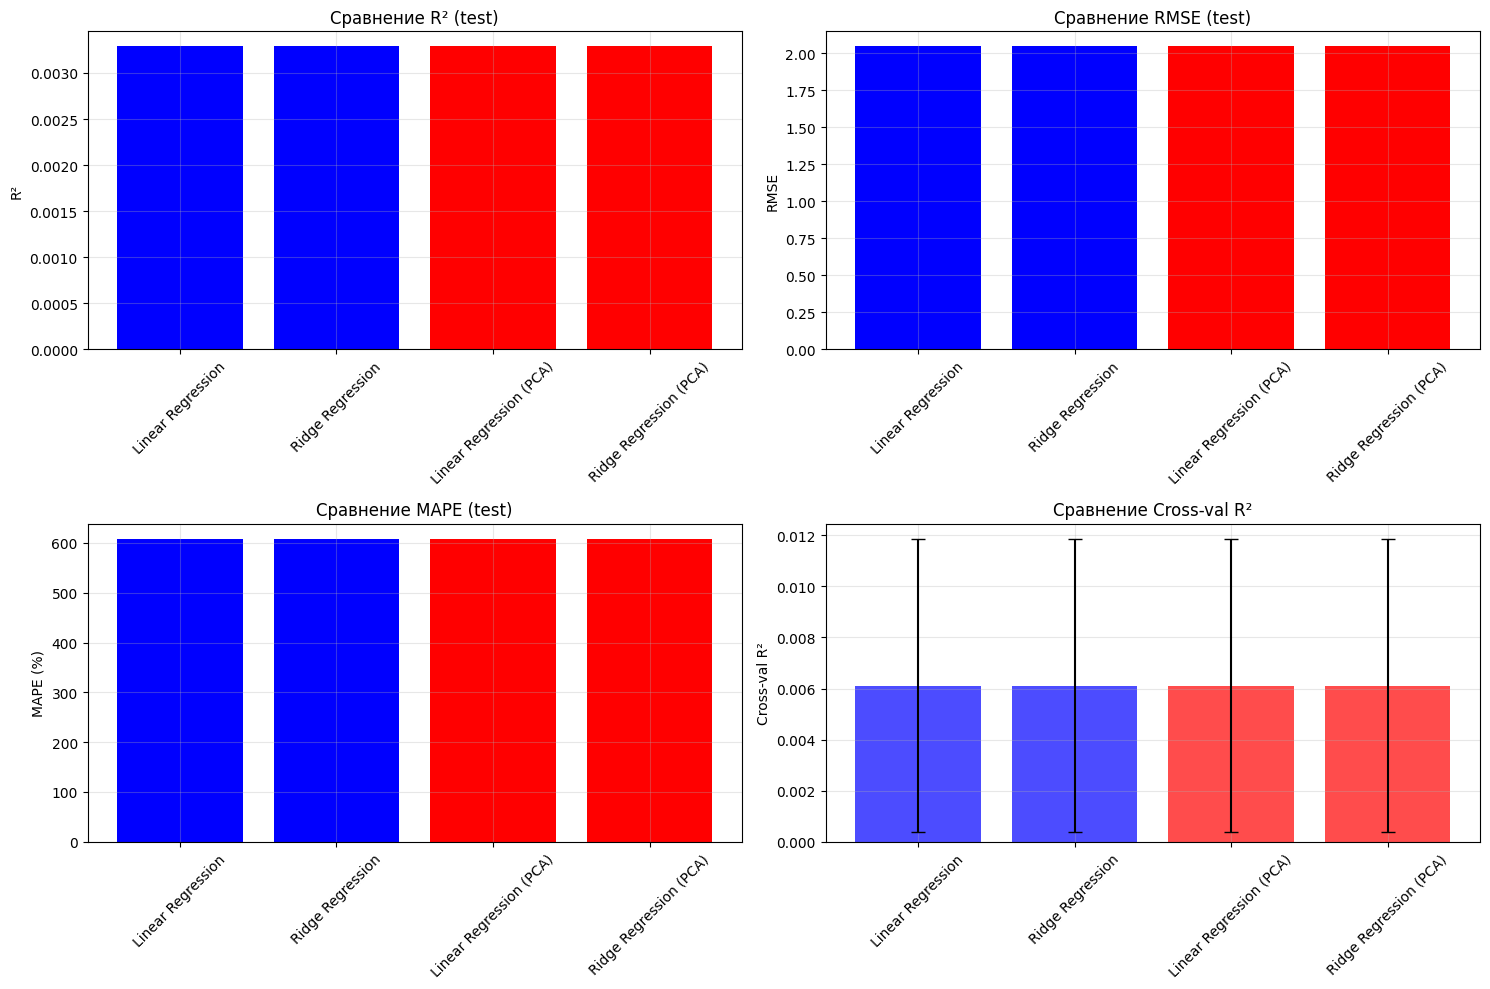


ДЕТАЛЬНОЕ СРАВНЕНИЕ МЕТРИК:
                     Model  RMSE_test  R2_test  MAPE_test  CV_R2_mean
0        Linear Regression     2.0464   0.0033   607.8021      0.0061
1         Ridge Regression     2.0464   0.0033   607.8065      0.0061
2  Linear Regression (PCA)     2.0464   0.0033   607.8021      0.0061
3   Ridge Regression (PCA)     2.0464   0.0033   607.8065      0.0061

АНАЛИЗ ИЗМЕНЕНИЙ ПОСЛЕ ПРИМЕНЕНИЯ PCA:
--------------------------------------------------

Linear Regression:
  RMSE: 2.0464 -> 2.0464 (изменение: +0.0000)
  R²: 0.0033 -> 0.0033 (изменение: -0.0000)
  MAPE: 607.80% -> 607.80% (изменение: +0.00%)

Ridge Regression:
  RMSE: 2.0464 -> 2.0464 (изменение: +0.0000)
  R²: 0.0033 -> 0.0033 (изменение: +0.0000)
  MAPE: 607.81% -> 607.81% (изменение: +0.00%)


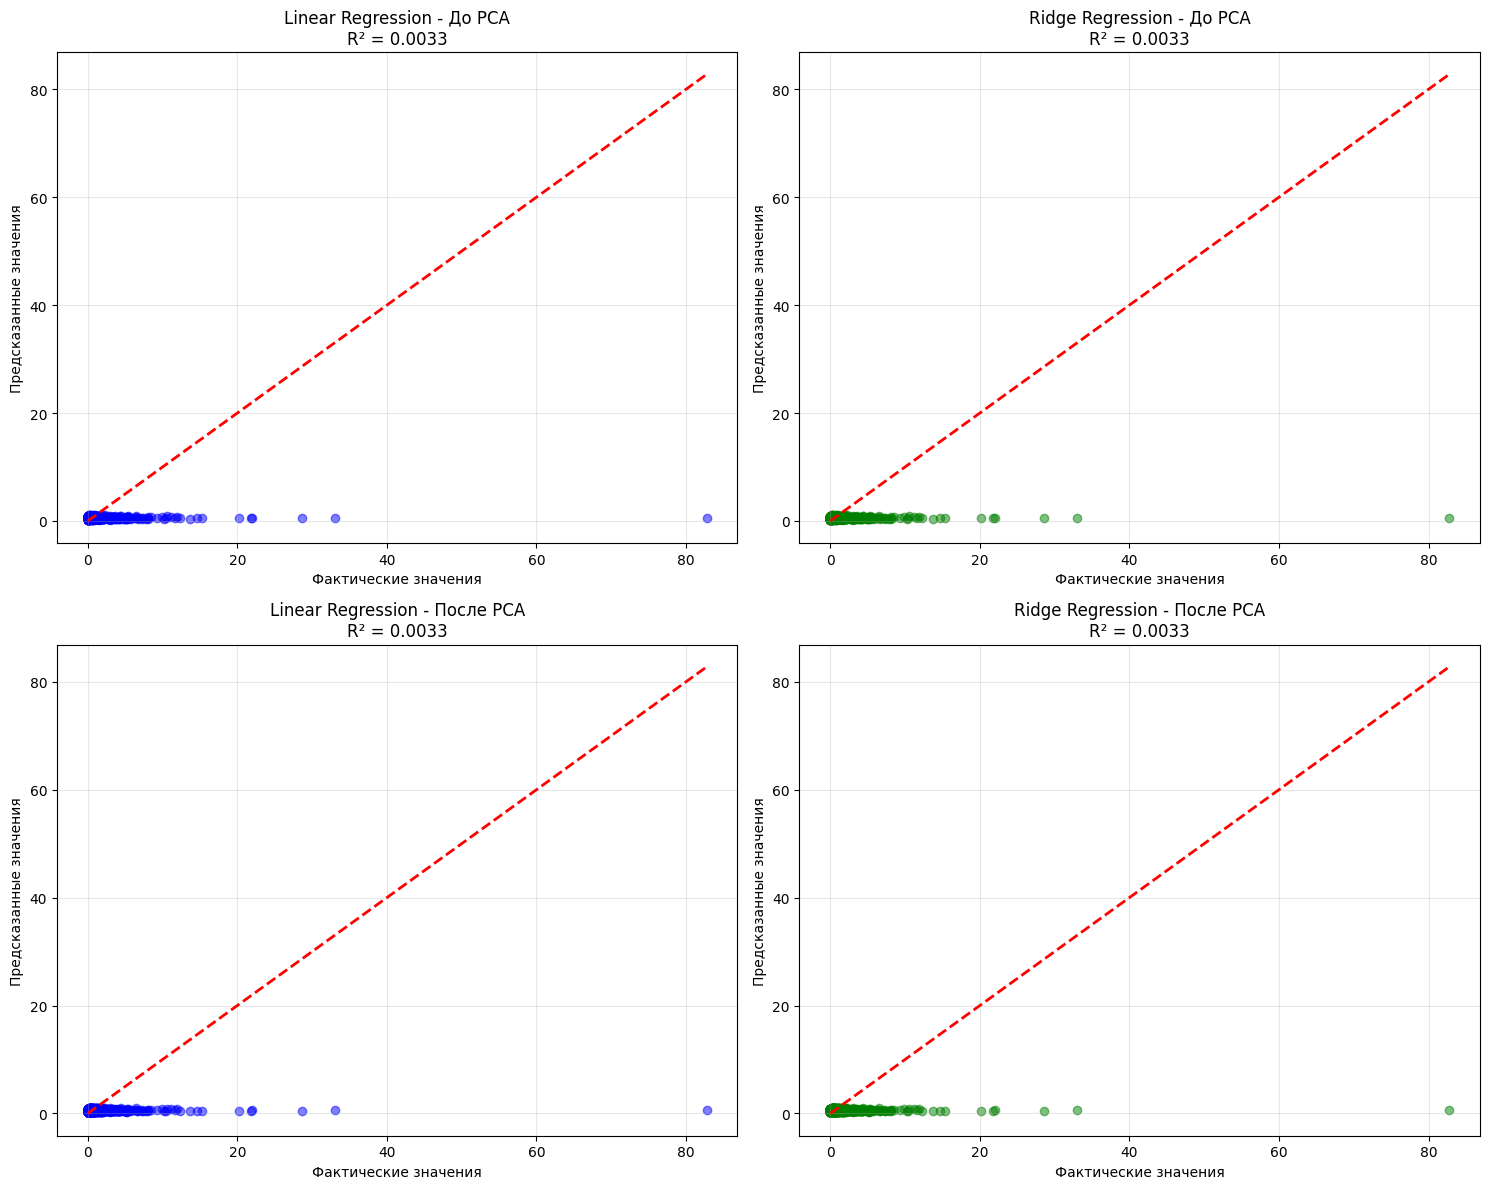


АНАЛИЗ ГЛАВНЫХ КОМПОНЕНТ:
Объясненная дисперсия по компонентам:
Компонента 1: 0.2988 (29.88%)
Компонента 2: 0.2653 (26.53%)
Компонента 3: 0.2404 (24.04%)
Компонента 4: 0.1955 (19.55%)

Суммарная объясненная дисперсия: 1.0000


In [ ]:
print("ПРИМЕНЕНИЕ PCA И ПОСТРОЕНИЕ МОДЕЛЕЙ НА ГЛАВНЫХ КОМПОНЕНТАХ")
print("=" * 80)

pca = PCA(n_components=selected_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Применен PCA с {selected_components} компонентами")
print(f"Объясненная дисперсия: {np.sum(pca.explained_variance_ratio_):.4f}")

results_after_pca = []
predictions_pca = {}

for name, model in models.items():
    results, y_pred = evaluate_model(model, X_train_pca, X_test_pca, y_train, y_test, name + " (PCA)")
    results_after_pca.append(results)
    predictions_pca[name] = y_pred
    
    print(f"\n{name} (PCA):")
    print(f"  RMSE (train/test): {results['RMSE_train']:.4f} / {results['RMSE_test']:.4f}")
    print(f"  R² (train/test): {results['R2_train']:.4f} / {results['R2_test']:.4f}")
    print(f"  MAPE (train/test): {results['MAPE_train']:.2f}% / {results['MAPE_test']:.2f}%")
    print(f"  Cross-val R²: {results['CV_R2_mean']:.4f} (±{results['CV_R2_std']:.4f})")

results_df_after = pd.DataFrame(results_after_pca)
print("\nСводная таблица метрик после PCA:")
print(results_df_after.round(4))

print("\n" + "=" * 80)
print("СРАВНЕНИЕ МЕТРИК ДО И ПОСЛЕ ПРИМЕНЕНИЯ PCA")
print("=" * 80)

all_results = pd.concat([results_df_before, results_df_after], ignore_index=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

models_names = all_results['Model']
r2_test = all_results['R2_test']

axes[0, 0].bar(models_names, r2_test, color=['blue', 'blue', 'red', 'red'])
axes[0, 0].set_title('Сравнение R² (test)')
axes[0, 0].set_ylabel('R²')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

rmse_test = all_results['RMSE_test']
axes[0, 1].bar(models_names, rmse_test, color=['blue', 'blue', 'red', 'red'])
axes[0, 1].set_title('Сравнение RMSE (test)')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

mape_test = all_results['MAPE_test']
axes[1, 0].bar(models_names, mape_test, color=['blue', 'blue', 'red', 'red'])
axes[1, 0].set_title('Сравнение MAPE (test)')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

cv_r2 = all_results['CV_R2_mean']
cv_std = all_results['CV_R2_std']
axes[1, 1].bar(models_names, cv_r2, yerr=cv_std, 
               color=['blue', 'blue', 'red', 'red'], alpha=0.7, capsize=5)
axes[1, 1].set_title('Сравнение Cross-val R²')
axes[1, 1].set_ylabel('Cross-val R²')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nДЕТАЛЬНОЕ СРАВНЕНИЕ МЕТРИК:")
comparison_df = all_results[['Model', 'RMSE_test', 'R2_test', 'MAPE_test', 'CV_R2_mean']].round(4)
print(comparison_df)

print("\nАНАЛИЗ ИЗМЕНЕНИЙ ПОСЛЕ ПРИМЕНЕНИЯ PCA:")
print("-" * 50)

for i in range(len(models)):
    model_name = list(models.keys())[i]
    
    # Метрики до PCA
    rmse_before = results_before_pca[i]['RMSE_test']
    r2_before = results_before_pca[i]['R2_test']
    mape_before = results_before_pca[i]['MAPE_test']
    
    # Метрики после PCA
    rmse_after = results_after_pca[i]['RMSE_test']
    r2_after = results_after_pca[i]['R2_test']
    mape_after = results_after_pca[i]['MAPE_test']
    
    print(f"\n{model_name}:")
    print(f"  RMSE: {rmse_before:.4f} -> {rmse_after:.4f} (изменение: {rmse_after - rmse_before:+.4f})")
    print(f"  R²: {r2_before:.4f} -> {r2_after:.4f} (изменение: {r2_after - r2_before:+.4f})")
    print(f"  MAPE: {mape_before:.2f}% -> {mape_after:.2f}% (изменение: {mape_after - mape_before:+.2f}%)")

#Визуализация предсказаний
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for idx, (name, color) in enumerate(zip(['Linear Regression', 'Ridge Regression'], ['blue', 'green'])):
    # До PCA
    axes[0, idx].scatter(y_test, predictions[name], alpha=0.5, color=color)
    axes[0, idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0, idx].set_xlabel('Фактические значения')
    axes[0, idx].set_ylabel('Предсказанные значения')
    axes[0, idx].set_title(f'{name} - До PCA\nR² = {results_before_pca[idx]["R2_test"]:.4f}')
    axes[0, idx].grid(True, alpha=0.3)
    
    # После PCA
    axes[1, idx].scatter(y_test, predictions_pca[name], alpha=0.5, color=color)
    axes[1, idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[1, idx].set_xlabel('Фактические значения')
    axes[1, idx].set_ylabel('Предсказанные значения')
    axes[1, idx].set_title(f'{name} - После PCA\nR² = {results_after_pca[idx]["R2_test"]:.4f}')
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("\nАНАЛИЗ ГЛАВНЫХ КОМПОНЕНТ:")
print("Объясненная дисперсия по компонентам:")
for i, variance in enumerate(pca.explained_variance_ratio_, 1):
    print(f"Компонента {i}: {variance:.4f} ({variance*100:.2f}%)")

print(f"\nСуммарная объясненная дисперсия: {np.sum(pca.explained_variance_ratio_):.4f}")

# Сравнение моделей регрессии

## Линейная регрессия

| Метрика | Обычная LR | LR с PCA |
|---------|------------|----------|
| R² (тест) | 0.0033 | 0.0033 |
| R² (кросс-валидация) | 0.0061 | 0.0061 |
| MAPE | 607.80% | 607.80% |
| RMSE | 2.0464 | 2.0464 |
| Количество признаков | 4 | 4 |

## Гребневая регрессия

| Метрика | Обычная Ridge | Ridge с PCA |
|---------|---------------|-------------|
| R² (тест) | 0.0033 | 0.0033 |
| R² (кросс-валидация) | 0.0061 | 0.0061 |
| MAPE | 607.81% | 607.81% |
| RMSE | 2.0464 | 2.0464 |
| Лучшая альфа | 1.0 | 1.0 |

## Выводы

**PCA не оказал влияния на качество моделей:**

- Все метрики остались идентичными (R², MAPE, RMSE)
- Кросс-валидация показывает одинаковую стабильность
- Объясненная дисперсия распределена равномерно по компонентам (29.88%, 26.53%, 24.04%, 19.55%)

**Причины отсутствия эффекта от PCA:**

1. **Исходное количество признаков небольшое** (4 признака), поэтому PCA не дает преимущества в сокращении размерности
2. **Отсутствие мультиколлинеарности** (VIF ≈ 1.0 для всех признаков) делает PCA избыточным
3. **Основная проблема** - низкая предсказательная сила самих признаков, а не их взаимная корреляция


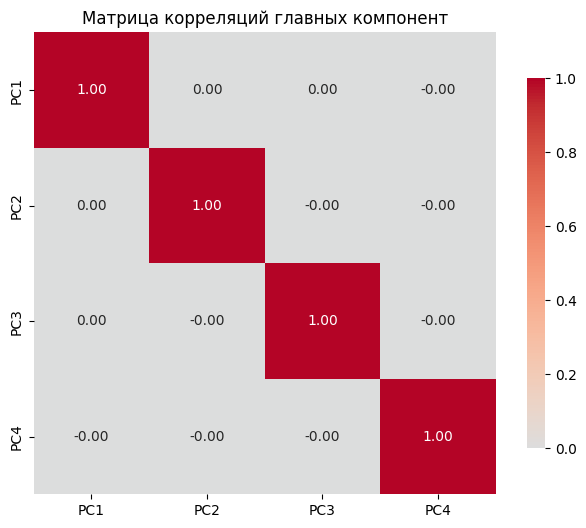

In [ ]:
pca_columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
df_pca = pd.DataFrame(X_train_pca, columns=pca_columns)

corr_matrix_pca = df_pca.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_pca, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            square=True,
            fmt=".2f",
            cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций главных компонент')
plt.show()

# Вывод по матрице корреляций главных компонент

- **Главные компоненты абсолютно некоррелированы** (все недиагональные элементы = 0)
- **Каждая компонента имеет единичную дисперсию** (диагональные элементы = 1.00)
- **PCA выполнен корректно** - компоненты ортогональны и несут независимую информацию

**Результат:** Успешное применение метода главных компонент, полученные компоненты пригодны для дальнейшего анализа.